In [1]:
'''

Finger flexion prediction using transformer encoder
@author: Deng Chijun
@create date: 2024.11.24
@update date: 2024.11.26

'''
import logging
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import StepLR
import pickle


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns


torch.manual_seed(0) 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
'''
Transformer Encoder
'''
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim, pos_dim, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, pos_dim, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(embed_dim, output_dim)
    
    def forward(self, x):
        # Reshape input for embedding
        x = x.permute(0, 2, 1)  # (batch_size, freq, channels)
        x = self.embedding(x) + self.positional_encoding 
        
        x = x.permute(1, 0, 2)  # (freq, batch_size, embed_dim)
        x = self.transformer_encoder(x)
        
        x = x.mean(dim=0)  # Aggregate over the frequency dimension
        x = self.fc(x) 
        return x


2024-11-26 20:37:21,630 - INFO - sub1 thumb flexion prediction using transformer encoder


Epoch 1/10, Loss: 0.0664
Epoch 2/10, Loss: 0.0172
Epoch 3/10, Loss: 0.0153
Epoch 4/10, Loss: 0.0147
Epoch 5/10, Loss: 0.0143
Epoch 6/10, Loss: 0.0139
Epoch 7/10, Loss: 0.0137
Epoch 8/10, Loss: 0.0137
Epoch 9/10, Loss: 0.0140
Epoch 10/10, Loss: 0.0145
Test Loss: 0.0321


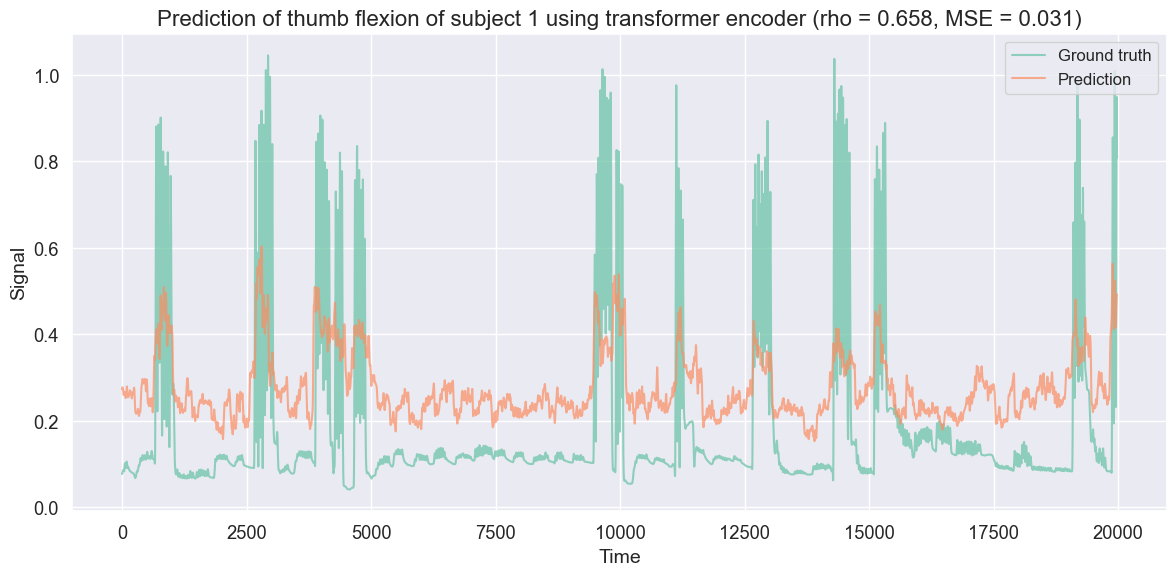

2024-11-26 20:41:04,867 - INFO - sub1 index flexion prediction using transformer encoder


Epoch 1/10, Loss: 0.0253
Epoch 2/10, Loss: 0.0197
Epoch 3/10, Loss: 0.0156
Epoch 4/10, Loss: 0.0135
Epoch 5/10, Loss: 0.0126
Epoch 6/10, Loss: 0.0121
Epoch 7/10, Loss: 0.0115
Epoch 8/10, Loss: 0.0111
Epoch 9/10, Loss: 0.0108
Epoch 10/10, Loss: 0.0106
Test Loss: 0.0122


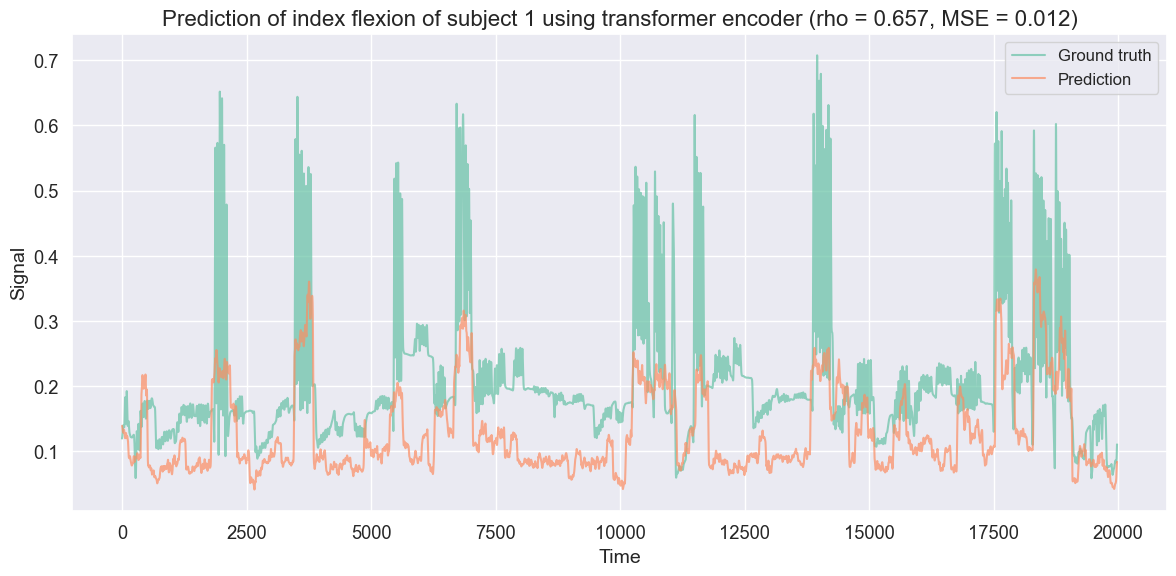

2024-11-26 20:44:45,172 - INFO - sub1 middle flexion prediction using transformer encoder


Epoch 1/10, Loss: 0.0209
Epoch 2/10, Loss: 0.0187
Epoch 3/10, Loss: 0.0179
Epoch 4/10, Loss: 0.0173
Epoch 5/10, Loss: 0.0168
Epoch 6/10, Loss: 0.0165
Epoch 7/10, Loss: 0.0158
Epoch 8/10, Loss: 0.0155
Epoch 9/10, Loss: 0.0145
Epoch 10/10, Loss: 0.0143
Test Loss: 0.0103


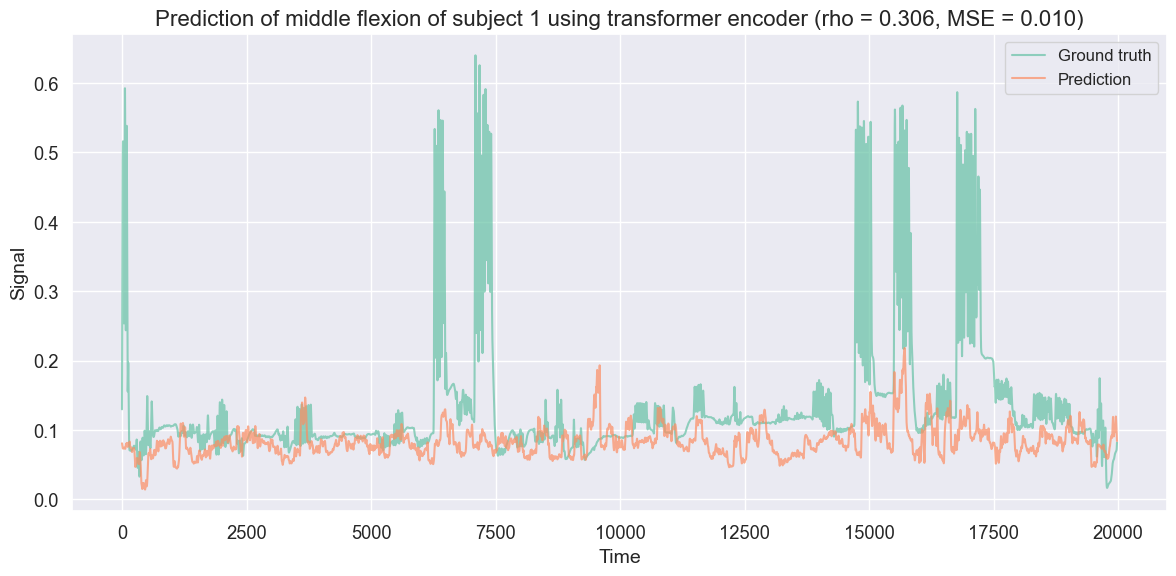

2024-11-26 20:48:25,575 - INFO - sub1 ring flexion prediction using transformer encoder


KeyboardInterrupt: 

In [3]:
'''
Train and test for each subject and finger
'''
# Preprocessed data directory (feature)
root_dir = "/Users/miaolab/Desktop/dengchijun/coursework/bci"
process_dir = f"{root_dir}/BCI_Competion4_dataset4_data_fingerflexions/preprocessing"

# Results directory
pred_dir = f"{root_dir}/BCI-Finger-Flex/prediction/transformer"
model_dir = f"{root_dir}/BCI-Finger-Flex/model/transformer"

# Gaussian filter sigma
sigma = 6

# Subjects and fingers
subs = [1, 2, 3]
fingers = ['thumb', 'index', 'middle', 'ring', 'little']

for idx, subid in enumerate(subs):
    '''
    Data loading
    '''
    data_process_dir = f'{process_dir}/sub{subid}'
    
    # train
    X_train = np.load(f'{data_process_dir}/train/ecog_data.npy')
    y_train_all = np.load(f'{data_process_dir}/train/fingerflex_data.npy')
    
    # test
    X_test = np.load(f'{data_process_dir}/val/ecog_data.npy')
    y_test_all = np.load(f'{data_process_dir}/val/fingerflex_data.npy')
    
    # Transpose to (times, channels, wavelets)
    X_train = X_train.transpose(2, 0, 1)
    X_test = X_test.transpose(2, 0, 1)
    y_train_all = y_train_all.transpose(1, 0)
    y_test_all = y_test_all.transpose(1, 0)
    
    # Feature dim
    num_wave = X_train.shape[2]
    num_node = X_train.shape[1]
    
    '''
    Model Setup
    '''
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    
    model = TransformerRegressor(input_dim=num_node, embed_dim=256, num_heads=8,
                                 num_layers=2, output_dim=1,
                                 pos_dim=num_wave).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    '''
    Save dir
    '''
    # Model save dir
    model_finger_dir = f"{model_dir}/sub{subid}"
    if not os.path.exists(model_finger_dir):
        os.makedirs(model_finger_dir)
        logging.info(f"Directory '{model_finger_dir}' created.")

    # Prediction save dir
    pred_finger_dir = f"{pred_dir}/sub{subid}"
    if not os.path.exists(pred_finger_dir):
        os.makedirs(pred_finger_dir)
        logging.info(f"Directory '{pred_finger_dir}' created.")
            
    for finger_id, finger_name in enumerate(fingers):
        # logging train and validation process
        logging.info(f"Subject {subid} {finger_name} flexion prediction using transformer encoder")
        '''
        Torch dataloader
        '''
        y_train = y_train_all[:, finger_id].reshape([-1, 1])
        y_test = y_test_all[:, finger_id].reshape([-1, 1])
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        
        batch_size = 128
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Train epoch
        epochs = 10
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Save model
        torch.save(model.state_dict(), f"{model_finger_dir}/{finger_name}.pth")

        '''
        Evaluation and Inference
        '''
        y_pred = []
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                test_loss += loss.item()
                
                y_pred.append(predictions.cpu().numpy())
                
        y_pred = np.concatenate(y_pred, axis=0)  # Combine batch predictions
        
        print(f"Test Loss: {test_loss / len(test_loader):.4f}")
        
        '''
        Calculating Pearson correlation, MSE metrics
        '''
        y_pred_filter = gaussian_filter1d(y_pred.ravel(), sigma=sigma)
        rho, pval = pearsonr(y_test.ravel(), y_pred_filter)
        mse = mean_squared_error(y_test.ravel(), y_pred_filter)

        # Save prediction and metrics
        pred_res = {
            'y_test': y_test.ravel(),
            'y_pred': y_pred.ravel(),
            'y_pred_filter': y_pred_filter.ravel(),
            'rho': rho,
            'pval': pval,
            'mse': mse
        }
        with open(f"{pred_finger_dir}/{finger_name}.pkl", 'wb') as pickle_file:
            pickle.dump(pred_res, pickle_file)
        
        '''
        Visualization
        '''
        sns.set_theme(style='darkgrid', font_scale=1.2)
        colors = sns.color_palette("Set2", 2) 
        
        plt.figure(figsize=(12, 6))
        # Plot original y
        plt.plot(y_test.ravel(), label="Ground truth", alpha=0.7, color=colors[0])
        # Plot predicted y
        plt.plot(y_pred_filter.ravel(), label="Prediction", alpha=0.7, color=colors[1])
        
        # Adding labels and legend
        plt.title(f"Prediction of {finger_name} flexion of subject {subid} using transformer encoder (rho = {rho:.3f}, MSE = {mse:.3f})", fontsize=16)
        plt.xlabel("Time", fontsize=16)
        plt.ylabel("Signal", fontsize=16)
        plt.legend(fontsize=14, loc='upper right')
        plt.grid(True)
        plt.tight_layout()

        # Save figure
        plt.savefig(f"{pred_finger_dir}/{finger_name}.png", bbox_inches='tight', dpi=300)
        plt.show()